In [67]:
#%pip install tqdm torchvision torch numpy matplotlib scikit-learn

## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [68]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [69]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [70]:
class Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(Baseline, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Полносвязные слои
        self.fc1 = nn.Linear(in_features=32 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Прямой проход через сверточные слои
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        # Вытягивание в одномерный вектор
        x = x.view(x.size(0), -1)

        # Прямой проход через полносвязные слои
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

Files already downloaded and verified
Files already downloaded and verified


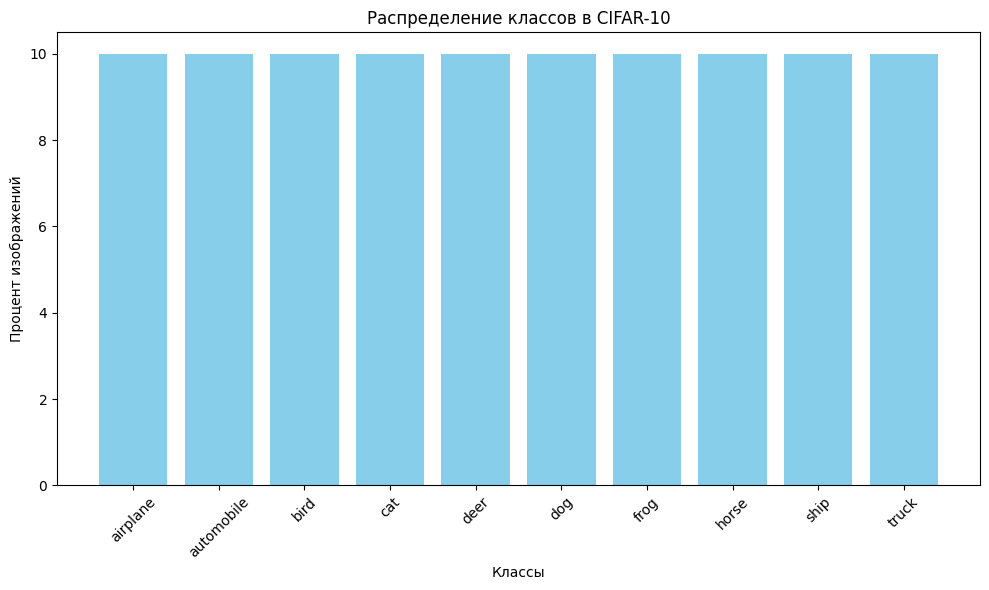

In [71]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

# Загрузим датасеты для train и test
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построение диаграммы
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts, color='skyblue')
plt.xlabel('Классы')
plt.ylabel('Процент изображений')
plt.title('Распределение классов в CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

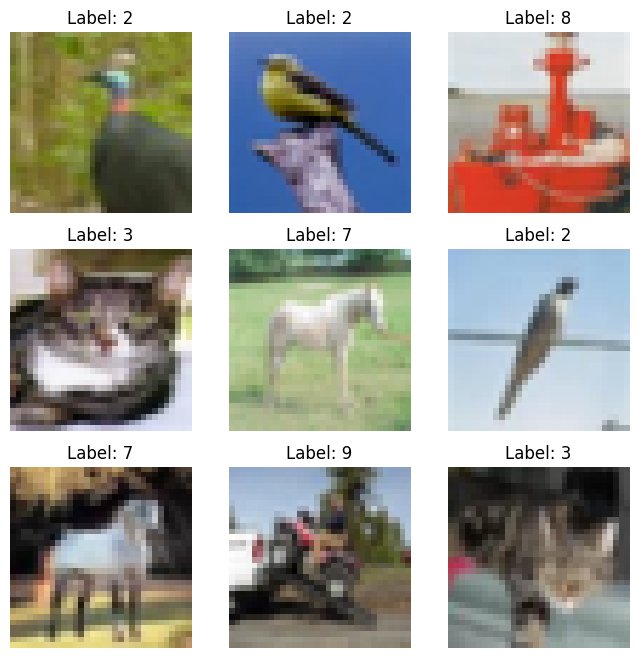

In [72]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

# Создайте сетку 3x3 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  # Перевести изображение из формата (C, H, W) в (H, W, C)
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Датасет можно считать сбалансированным, так как он содержит 10 классов, каждый из которых представлен 6 тысячами изображений, что подтверждается равномерным распределением на гистограмме.
\
\
Исходя из этого, какие метрики будем применять для оценки качества модели?
\
Можно использовать такие стандартные метрики, как точность (Accuracy) и кросс-энтропийная ошибка (Cross-Entropy Loss).

Напишем функции train и test

In [73]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model = model.to(device)
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training phase
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} (Train)', ncols=80):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} (Val)', ncols=80):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct / val_total)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]*100:.2f}%, Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc_history[-1]*100:.2f}%')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / total

    return accuracy, avg_loss

Сделайте разделение на train и val
\
Зачем так делать?
\
Разделение на train и val нужно делать, чтобы оценить работу модели с незнакомыми для нее данными

In [74]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}')

Train size: 40000, Val size: 10000


Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?
\
Мы используем оптимизатор Adam, потому что он является самым распространенным и испольузет самые оптимальные параметры обучения, и функцию CrossEntropyLoss

In [75]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
import torch.nn as nn

# Гиперпараметры
learning_rate = 0.001
num_epochs = 20
batch_size = 1024

# Создаем модель
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(4096, 10)
model = model.to('cuda') if torch.cuda.is_available() else model

print('Model params: ', count_parameters(model))

# Определяем функцию потерь и оптимизатор
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  134301514


Обучите модель и постройте графики обучения

In [76]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=num_epochs)

Epoch 1/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  3.18it/s]


Epoch 1/20: Train Loss: 2.6453, Train Acc: 10.80%, Val Loss: 2.2961, Val Acc: 9.91%


Epoch 2/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  2.73it/s]


Epoch 2/20: Train Loss: 2.3092, Train Acc: 10.90%, Val Loss: 2.2992, Val Acc: 9.91%


Epoch 3/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  3.18it/s]


Epoch 3/20: Train Loss: 2.2959, Train Acc: 11.39%, Val Loss: 2.2169, Val Acc: 17.40%


Epoch 4/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch 4/20: Train Loss: 2.0609, Train Acc: 17.87%, Val Loss: 1.9007, Val Acc: 21.44%


Epoch 5/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch 5/20: Train Loss: 1.8083, Train Acc: 24.55%, Val Loss: 1.7413, Val Acc: 27.88%


Epoch 6/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch 6/20: Train Loss: 1.6760, Train Acc: 31.42%, Val Loss: 1.4975, Val Acc: 39.82%


Epoch 7/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  2.99it/s]


Epoch 7/20: Train Loss: 1.4791, Train Acc: 37.45%, Val Loss: 1.4321, Val Acc: 40.74%


Epoch 8/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch 8/20: Train Loss: 1.2725, Train Acc: 47.30%, Val Loss: 1.2397, Val Acc: 54.48%


Epoch 9/20 (Val): 100%|█████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch 9/20: Train Loss: 0.9947, Train Acc: 62.98%, Val Loss: 1.3303, Val Acc: 58.01%


Epoch 10/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  2.71it/s]


Epoch 10/20: Train Loss: 0.8049, Train Acc: 72.69%, Val Loss: 0.9871, Val Acc: 68.97%


Epoch 11/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


Epoch 11/20: Train Loss: 0.6720, Train Acc: 77.59%, Val Loss: 0.7386, Val Acc: 75.78%


Epoch 12/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  3.04it/s]


Epoch 12/20: Train Loss: 0.4721, Train Acc: 84.40%, Val Loss: 0.5830, Val Acc: 81.53%


Epoch 13/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  2.92it/s]


Epoch 13/20: Train Loss: 0.3792, Train Acc: 87.65%, Val Loss: 0.6764, Val Acc: 81.07%


Epoch 14/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch 14/20: Train Loss: 0.2906, Train Acc: 90.52%, Val Loss: 0.6872, Val Acc: 81.54%


Epoch 15/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch 15/20: Train Loss: 0.2094, Train Acc: 93.45%, Val Loss: 0.9411, Val Acc: 78.44%


Epoch 16/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch 16/20: Train Loss: 0.2550, Train Acc: 92.32%, Val Loss: 0.6788, Val Acc: 82.00%


Epoch 17/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


Epoch 17/20: Train Loss: 0.1486, Train Acc: 95.38%, Val Loss: 0.6444, Val Acc: 84.37%


Epoch 18/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


Epoch 18/20: Train Loss: 0.1091, Train Acc: 96.69%, Val Loss: 0.6836, Val Acc: 83.61%


Epoch 19/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch 19/20: Train Loss: 0.0843, Train Acc: 97.48%, Val Loss: 0.7284, Val Acc: 84.21%


Epoch 20/20 (Val): 100%|████████████████████████| 10/10 [00:03<00:00,  3.09it/s]

Epoch 20/20: Train Loss: 0.0669, Train Acc: 98.05%, Val Loss: 0.7820, Val Acc: 83.19%


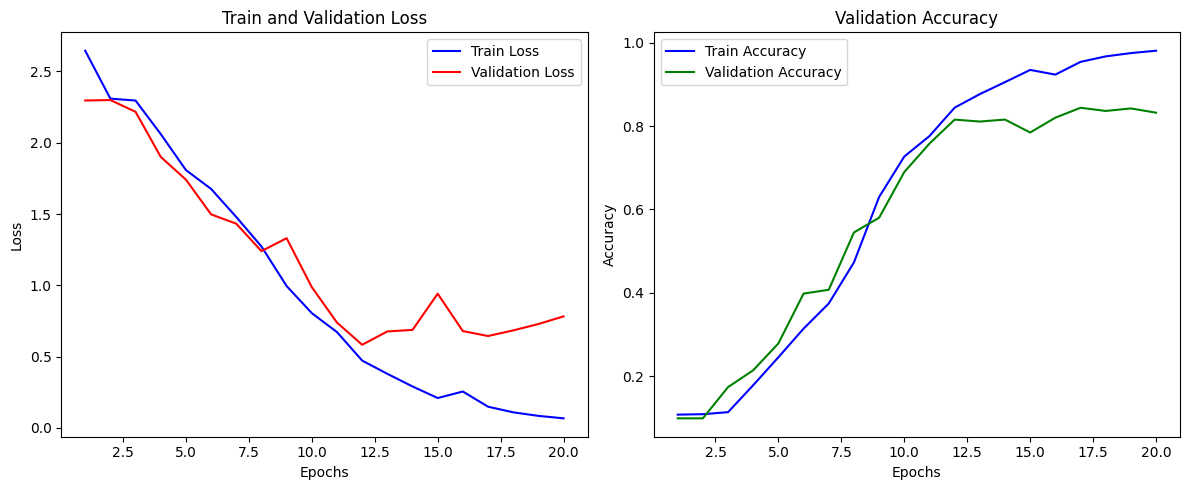

In [77]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения
\
Исходя из графика, можно сказать, что происходят резкие скачки в обучении
\
Если увеличить количество эпох, то примерно с 24-й эпохи модель переобучается

Оцените тестовую метрику на тестовых данных

In [78]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.8773
Test Accuracy: 82.0900


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов